# Assignment #4 - Reinforcement Learning

### <font color="red"> DUE: Dec 1 (Tuesday) 11:00 pm </font>  

<font color="blue"> Yike Li </font>

# I. Overview

**Describe the objective of this assignment. You can briefly state how you accomplish it.**

In this assignment, we work on 2 RL problems using NN as the function estimator: the 2D marble movement problem and the mountain car problem. The 2D marble environment is defined based on the 1D marble class provided in the class note. For the second problem, we leverage the mountain car environment in OpenAI and build our RLAgent to interact with the environment. Both problems are straightforward to solve, but we are having tremendous difficulty in having the NN function estimator converged. In this report, we have delivered the best results we can get and visualize the RL agent performance. 

# II. Problems 

## 2D Marble Control

![image.png](attachment:image.png)

#### STEPS for 2D Marble

1. [II Problems] First, build 2D marble class by extending the Marble class from the class note. 
2. [II Problems] Explain the environment.
3. [III Methods] Build your own RLAgent class to solve the problem.
4. [III Methods] Explain your RLAgent (with a neural network function approximator)
5. [IV Results]  Discuss the results

We import the necessary python packages in the following cell.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as ipd  # for display and clear_output
import collections
from copy import deepcopy as copy

Below we create a `Marble2D` class to build up the environment for the Marble problem in the 2-dimensional space. In the 2-dimensional space, the state of our marble will be 4 dimensions (instead of 2 in the 1D problem): 
- the x-coordinate of the marble
- the y-coordinate of the marble
- the velocity along the x-coordinate (dx)
- the velocity along the y-coordinate (dy)

Correspondingly, we have the action (1 dimensional) with 5 possible values:
- action=1: force moving down
- action=2: force moving up
- action=3: force moving left
- action=4: force moving right
- action=5: no force

In `__init__`, We set our boundary to be a squared region with a length of 10. We have our goal to be a squared region centered at [5,5] with a width of 2. 
In `next`, whenever the marble exceeds the boundary, it will be placed back to the corresponding boundary (up, down, right, or left) and set velocity along that axis to be 0. Also, if the velocity is above a certain threshold (-5 or 5 in this case), the velocity will be set back to the threshold. 

For the reward function, if the marble reached the goal region, it is getting reward of 30. Moving a step will cause the reward to be -1. 

In [17]:
class Marble2D():
    """ 2D marble problem

        states: x, y, dx, dy
        action: [[0, -1], [0, 1], [-1, 0], [1, 0], [0, 0]], down, up, left, right, no force, repectively
        action: [1:down, 2:up, 3:left, 4:right, 5: no force]


    """

    def __init__(self, goal=[5, 5], **params):
        self.n_state = 4  # no. of state, x(position), y(position), dx(velocity on x), dy(velocity on y)
        self.n_action = 5  # no. of actions
        self.Goal = goal  # position of the goal, should be at 5 (between 4 and 6). Change for 2D.
        self.bound = params.pop('bound', [0, 10, 0, 10, -5, 5, -5,
                                          5])  # define the bound of each state. first 4 for x and y; last 4 for velocity.
        # if len(self.bound) != 8:
        #     self.bound = self.bound[:2] + [-5, 5]  # [-5, 5]是速度dx的限制，最大是-5或5

        # array([[ 0, -5, -1],
        #        [10,  5,  1]]) 下面的输出。第一二三列分别为x，dx和action的范围
        # 一二三四五列分别为x,y,dx,dy,action的范围
        self._st_range = np.array([self.bound[:2], self.bound[2:4], self.bound[4:6], self.bound[6:8], [1, 4]]).T
        self.nnNI = self.n_state + 1  # =5
        self.goal_width = 2  # 中标的宽度为1*2=2，以[5, 5]为中心，(x,y)=([4-6], [4-6])都算是goal的区域

        self._s = [0, 0, 0, 0]  # _s=current state，起始为[x,y,dx,dy]=[0,0,0,0]

    def init(self, start=None):
        if start is not None:
            self._s = start  # specify starting position
        else:  # if starting not given, first ele(x) random within 0-10 and second ele(dx) as 0
            self._s = [np.random.randint(self.bound[0], self.bound[1]), np.random.randint(self.bound[2], self.bound[3]),
                       0., 0.]
        return self._s

    def get_random_action(self):
        return float(np.random.randint(4) + 1)  # randomly get action from 1 to 4

    def get_bound_act(self, a):  # 没用上。应该是用来规范action值的，当a>1取1，a<-1取-1
        if a[0] > 5:
            return 5
        elif a[0] < 1:
            return 1
        else:
            return a[0]

    def next(self, a):
        s = self._s  # 把当前位置传给s
        if isinstance(a, collections.Iterable):  # 判断action a是否为一个iterable(可迭代对象)
            a = a[0]  # 如果是，只把第一个ele给a
        s1 = copy(s)  # deep copy当前state(s)给下个state(s1)
        dT = 0.1  # 0.1是时间，0.1秒

        s1[0] += dT * s[2]  # 根据当前x的速度，时间(0.1)*速度为位移，更新下个x
        s1[1] += dT * s[3]  # 根据当前y的速度，时间(0.1)*速度为位移，更新下个y
        if a == 1: s1[3] += dT * (2 * -1 - 0.2 * s[3])  # 更新dy,Move down,往y轴负方向的力量)
        if a == 2: s1[3] += dT * (2 * +1 - 0.2 * s[3])  # 更新dy,Move up,往y轴正方向的力量)
        if a == 3: s1[2] += dT * (2 * -1 - 0.2 * s[2])  # 更新dx,Move left,往x轴负方向的力量)
        if a == 4: s1[2] += dT * (2 * +1 - 0.2 * s[2])  # 更新dx,Move right,往x轴正方向的力量)
        if a == 5: 
          s1[2] += dT * (2 * 0 - 0.2 * s[2])  # 更新dx, friction
          s1[3] += dT * (2 * 0 - 0.2 * s[3])  # 更新dy, friction

        # action: [[0, -1], [0, 1], [-1, 0], [1, 0], [0, 0]], down, up, left, right, no force, repectively
        # action: [1:down, 2:up, 3:left, 4:right, 5: no force]

        # adjust velocity when outside of the track, bound=[0,10,0,10]
        if s1[0] < self.bound[0]:  # 当下个x position超出了左边界
            s1[:] = [self.bound[0], s1[1], 0, s1[3]]  # 将下个状态设为(x,y,dx,dy)=(0,y,0,dy)
        elif s1[0] > self.bound[1]:  # 当下个x position超出了右边界
            s1[:] = [self.bound[1], s1[1], 0, s1[3]]  # 将下个状态设为(x,y,dx,dy)=(10,y,0,dy)
        elif s1[1] < self.bound[2]:  # 当下个y position超出了下边界
            s1[:] = [s1[0], self.bound[2], s1[2], 0]  # 将下个状态设为(x,y,dx,dy)=(x,0,dx,0)
        elif s1[1] > self.bound[3]:  # 当下个y position超出了上边界
            s1[:] = [s1[0], self.bound[3], s1[2], 0]  # 将下个状态设为(x,y,dx,dy)=(x,10,dx,0)

        # 将超出[-5,5]的dx变为-5或5
        # _st_range的一二三四五列分别为x,y,dx,dy,action的范围
        s1[2] = np.clip(s1[2], self._st_range[0, 2],  # 第一行第三列为-5
                        self._st_range[1, 2])  # 第二行第三列为5
        # 将超出[-5,5]的dy变为-5或5
        s1[3] = np.clip(s1[3], self._st_range[0, 3],  # 第一行第四列为-5
                        self._st_range[1, 3])  # 第二行第四列为5

        self._s = s1  # 下个状态存为当前状态
        return self.get_reward(s, s1, a)  # 根据下个状态确定reward。这里s和a都没用上

    def get_cur_state(self):  # 一个class的object用于外面调用的
        return self._s

    def get_reward(self, s, s1, a):  # 以[5, 5]为中心，(x,y)=([4-6], [4-6])都算是goal的区域
        return 30 if abs(s1[0] - self.Goal[0]) < self.goal_width and abs(
            s1[1] - self.Goal[1]) < self.goal_width else -1  # 如果在[5-1,5+1]内则为30，否则为-1

    def get_state_range(self):  # 一个class的object用于外面调用的
        return self._st_range

    def get_actions(self):  # 一个class的object用于外面调用的，显示所有可能的action
        return np.array([1, 2, 3, 4, 5])

    def get_action_index(self, action):  # 一个class的object用于外面调用的，显示当前action的index
        return np.where(np.array([1, 2, 3, 4, 5]) == action)[0][0]

    def draw_trajectory(self, smplX):  # unused
        if smplX.shape[1] == 1: return
        plt.plot(smplX[:, 0], smplX[:, 1])
        plt.axis([self.bound[0], self.bound[1], -5, 5])
        plt.plot(smplX[0, 0], smplX[0, 1], 'go')
        plt.plot(self.Goal, 0, 'ro')
        # draw a goal region
        plt.fill_between([self.Goal - self.goal_width, self.Goal + self.goal_width],
                         [-5, -5], [5, 5],
                         color="red", alpha=0.3)
        plt.xlabel("s")
        plt.ylabel("s dot")

class Standardizer: 
    """ class version of standardization """
    def __init__(self, X, explore=False):
        self._mu = np.mean(X,0)  
        self._sigma = np.std(X,0)
        if explore:
            print ("mean: ", self._mu)
            print ("sigma: ", self._sigma)
            print ("min: ", np.min(X,0))
            print ("max: ", np.max(X,0))

    def set_sigma(self, s):
        self._sigma[:] = s

    def standardize(self,X):
        return (X - self._mu) / self._sigma 

    def unstandardize(self,X):
        return (X * self._sigma) + self._mu 

## Mountain Car


<img src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCarContinuous-v0/poster.jpg" data-video-type="video/mp4" data-video-source="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCarContinuous-v0/original.mp4">



#### STEPS for Mountain Car

1. [II Problems] Learn the classic mountain car problem and explain it
2. [II Problems] Learn how to use the OpenAI Gym "MountainCarContinuous-v0" environment ([OpenAI Gym MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0/))
  2.a. Following the link, by clicking the document tab, you can learn how to install and use openai.gym
3. [III Methods] Build your own RLAgent class to solve the problem.
4. [III Methods] Explain your RLAgent (with a neural network function approximator)
5. [IV Results]  Discuss the results 

**[II Problems] Learn the classic mountain car problem and explain it**

The mountain car problem is a classic problem in the RL field. It has commonly been used as a benchmark RL problem to evaluate learning algorithms. 

In this problem, the car is placed between two mountains. The goal is to help the car to drive up the steep hill on the right. We can send commands such as driving left, driving right, or not using the engion. As the gravity of the car is considered and the engine of the car is not powerful to get itself directly to the top of the hill, the car would need to leverage potential energy by driving up to the hill on the left. Eventually, our RL algorithm is to learn the best control strategy that can let the car arrives the destination using a minimum amount of time. 

**[II Problems] Learn how to use the OpenAI Gym "MountainCarContinuous-v0" environment (OpenAI Gym MountainCarContinuous-v0) 2.a. Following the link, by clicking the document tab, you can learn how to install and use openai.gym**

OpenAI Gym is a Python package that includes various RL environments.
It was developed aiming at becoming a standardized environment and benchmark for RL research.

The following code imports the gym package and instantiate the MountainCar environment. From the code output, we can tell the state space of the environment is 2-dimensional: the first element denotes the position of the car and the second gives the velocity of the car. the first element of the state vector (representing the cart’s position) can take on any value in the range -1.2 to 0.6, while the second element (representing the cart’s velocity) can take on any value in the range -0.07 to 0.07. 

There can be three (discrete) actions: 0, 1 or 2. 0 means move left, 1 means stop the engion, and 2 means move right. 

In [ ]:
import gym
# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
s = env.reset()

# the dimension of state and action space
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)

# range of values the elements of the state vector can take
print('Lower Bound of state space: ', env.observation_space.low)
print('Upper Bound of state space: ', env.observation_space.high)

State space:  Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Action space:  Discrete(3)
Lower Bound of state space:  [-1.2  -0.07]
Upper Bound of state space:  [0.6  0.07]


When we interact with the environment by sending an action, it will return us the next state, the reward of the action, and whether 200 steps have been reached. Below code shows when we send an action of 2, the car move slightly to the right and its velocity changes from 0 to a positive value. 

Depending on the reward, we can update our NN weights and make our network predict better on the best action given the current state.

In [ ]:
s = env.reset()
a = 2
s1, reward, done, _ = env.step(action=a)
print(f'Current state: {s}, action={a}, next state: {s1}')
print(f'Reward: {reward}. Done: {done}')

Current state: [-0.45317946  0.        ], action=2, next state: [-0.45270368  0.00047577]
Reward: -1.0. Done: False


# III. Methods

-	RLAgent1 for the first problem
-	Explanation of the RLAgent1
-	RLAgent2 for the first problem
-	Explanation of the RLAgent2

## RLAgent1 for the first problem
We create an `RLAgent1` to solve the first problem: Marble in a 2D space. Some class objects are defined in `__init__` method: the `n_actions` is the number of possible actions, which is 4 as indicated previously. The weight matrices V and W are defined. We instantiate the Standardizer class to standardize the input matrix of NN function estimator. 

In `epsilon_greedy`, if we are not randomly picking an action, we are to predict the Q value given the input from the state and the action and from the weight matriices V and W. We are to pick the action that leads to the higher Q value. 

In `train`, we defined quite a few hyperparameters, like the discount factor gamma, the initial epsilon value, the final epsilon value, the maximum steps, the number of episodes, the number of hidden units, the number of input neurons, and the learning rate. We randomly initialize the weight matrices V and W, then we follow the course example to train the NN function estimator. We continue this training process until we run through all the episodes. 

In [18]:
class RLAgent1:
    """
        Reinforcement Learning Agent Model for Marble2D problem with NN function approximation
    """

    def __init__(self, env):
        self.env = env  # 实例化Marble的environment
        # self.std = std
        self.n_actions = 5  # 五种action，[1,2,3,4,5]

        self.V = None
        self.W = None
        self.rh = None
        self.ro = None
        # self.stdX = None

        # Normalize # 实例化Standardizer这个class，input为state的range(3列)分别为x,dx,action的范围
        self.stdX = Standardizer(self.env.get_state_range())
        # rewards and step trace
        self.rtrace = []  # 这个list用来存每个episode(500步)所得到的reward总和
        self.etrace = []  # 用来存每个episode的epsilon值。是呈指数衰减的

    def epsilon_greedy(self, e, s):
        if np.random.rand() < e:  # <e, random select an action
            return np.random.randint(self.n_actions) + 1  # 注意这里+1是把[0,1,2,3,4]选出的数变成[1,2,3,4,5]其中一个
        else:  # >=e, select by the (predicted) max Q value
            # forward返回两个元素，只取第一个output Y。np.tile将s=(x,y,dx,dy)重复5遍变成一列叠起来成为5*5矩阵.
            # 后面部分把[1,2,3,4,5]变成一列。然后5*5和5*1矩阵横向合并变为5*5矩阵，这个矩阵作为NN的input。乘以weight就算出output
            # 这里输出的Q为4*1矩阵，代表每个action所对应的Q value。我们选最大Q value所对应的action
            Q, _ = self.forward(np.hstack((np.tile(s, (5, 1)), self.env.get_actions().reshape((-1, 1)))))
            max_as = np.where(Q == np.max(Q))[0] + 1  # 找到Q value最大的index，并加1，这样对应到[1,2,3,4,5]这5个action上
            return np.random.choice(max_as)  # 如果有多个最大Q value，随机选取一个

    # Add constant column of 1's。为input matrix加一列1，再进行forward pass
    def addOnes(self, A):
        return np.insert(A, 0, 1, axis=len(np.array(A).shape) - 1)

    def forward(self, X):
        X = self.stdX.standardize(X)  # 先standardize，然后再addOnes
        # Forward pass on training data。
        X1 = self.addOnes(X)
        Z = np.tanh(X1 @ self.V)  # 用tanh作为activation function
        Z1 = self.addOnes(Z)  # 再加一列1作为bias
        Y = Z1 @ self.W  # Y为输出
        return Y, Z

    def as_array(self, A):  # 把输入object变为numpy array
        A = np.array(A)
        if len(A.shape) == 1:
            return A.reshape((1, -1))
        return A

    def backward(self, error, Z, X):
        ### make sure the array shapes。确保array都是对的形状
        X = self.as_array(X)
        Z = self.as_array(Z)
        E = self.as_array(error)  # error是输出与真实值的差值

        Z1 = self.addOnes(Z)  # 同样加一列1为bias column
        X1 = self.addOnes(X)  # 同样加一列1为bias column

        # Backward pass - the backpropagation and weight update steps
        dV = self.rh * X1.T @ ((E @ self.W[1:, :].T) * (1 - Z ** 2))  # tanh的梯度公式
        dW = self.ro * Z1.T @ E  # tanh的梯度公式
        return dV, dW

    def train(self, start=[2,2], **params):
        # Parameters
        gamma = params.pop('gamma', 0.9)  # discount factor
        K = params.pop('K', 500)  # no. of episodes
        epsilon = params.pop('epsilon', 1.)  # epsilon的最大值。大于等于当前值，选Q value最大的action
        final_epsilon = params.pop('final_epsilon', 0.1)  # 最后(最小)的epsilon值
        max_steps = params.pop('max_steps', 500)  # no. of steps within each episode
        verbose = params.pop('verbose', True)  # if True, print training details
        plot = params.pop('plot', False)  # if True, print training details
        epsilon_decay = np.exp(np.log(final_epsilon) / K)  # epsilon指数递减，刚开始勇于explore，后来偏向exploitation
        ####################
        nHiddens = params.pop('nHiddens', 5)  # 5个hidden neuron
        nSamples = params.pop('nSamples', 1)  # 1个sample？不太懂
        nOutputs = params.pop('nOutputs', 1)  # 1个output，输出是预测下一步每个action对应的Q value
        nInputs = params.pop('nInputs', 5)  # 因为有5个action，所以6个input
        max_iter = params.pop('max_iter', 10)  # code里没用到。总共train 10个iteration？
        rhoh = params.pop('rhoh', 0.01)  # 定学习率，输入层(V)和输出层(W)
        rhoo = params.pop('rhoo', 0.01)  # 定学习率，输入层(V)和输出层(W)

        self.rh = rhoh / (nSamples * nOutputs)
        self.ro = rhoo / (nSamples * nOutputs)

        # Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
        # 5+1个input（有一个是bias），5个hidden neuron，合成6*6的matrix
        self.V = 0.1 * 2 * (np.random.uniform(size=(nInputs + 1, nHiddens)) - 0.5)
        # 6+1个input（有一个是bias），1个output，合成6*1的matrix
        self.W = 0.1 * 2 * (np.random.uniform(size=(1 + nHiddens, nOutputs)) - 0.5)

        # rewards and step trace
        self.rtrace = []  # 这个list用来存每个episode(500步)所得到的reward总和
        self.etrace = [epsilon]  # 用来存每个episode的epsilon值。是呈指数衰减的
        for j in range(K):

            if verbose and (j + 1) % 100 == 0: print("\tepisode #", j, "   ", end="")
            self.env.init(start + [0, 0])  # [float(np.random.randint(-5, 5, 1)), 0]). 初始化为从位置[2,2]开始，加速度dx dy为0
            s = self.env.get_cur_state()  # 将现在的state值传给s，这里的s是个list
            # selection an action
            a = self.epsilon_greedy(epsilon, s)  # 根据当前state来选action。Q value是用NN来predict每个action的Q value，从中取最大

            rewards = []  # 用来存放每一步(step)的reward，每个episode会清空这个list
            trace = np.array(s)  # 把list的s变成array
            for step in range(max_steps):
                # if verbose: print("\tstep #", step, "   ", end="")
                # move
                r1 = self.env.next(a)  # 从当前状态和选取的action获得reward, 这步会同时更新当前状态env.get_cur_state()
                s1 = self.env.get_cur_state()  # 得到下个状态
                a1 = self.epsilon_greedy(epsilon, s1)  # 根据下个状态s1来选下个action

                rewards.append(r1)  # 把每个step的reward存到list
                trace = np.vstack((trace, s1))  # 把每步的(x,dx)存到trace里，后面来plot

                # update neural networks
                Q1, _ = self.forward(np.hstack((s1, a1)))  # output of neural network is Q for next state
                Q, Z = self.forward(np.hstack((s, a)))  # output of neural network is Q for next state
                error = r1 + gamma * Q1 - Q  # use action value as index by adding one
                dV, dW = self.backward(error, Z, np.hstack((s, a)))  # 用backward算出更新梯度
                self.V += dV  # 进行更新
                self.W += dW  # 进行更新

                s = s1  # 移动到下个state
                a = a1  # 下个action变为当前action

            epsilon *= epsilon_decay  # 让epsilon随着episode衰减
            self.etrace.append(epsilon)  # 存放epsilon

            if verbose and (j + 1) % 100 == 0: print("Done (", np.sum(rewards), ")", f'final step={step}')

            self.rtrace.append(np.sum(rewards))

        if plot:
            fig = plt.figure(figsize=(16, 8))
            fig.add_subplot(121)
            plt.plot(self.rtrace, "b-")
            plt.ylabel("sum of rewards")
            plt.title("Reward of each Episode")
            fig.add_subplot(122)
            plt.plot(trace[:, 0], trace[:, 1], "k-")
            plt.fill_between([self.env.Goal[0] - self.env.goal_width, self.env.Goal[0] + self.env.goal_width],
                              [self.env.Goal[1] - self.env.goal_width, self.env.Goal[1] - self.env.goal_width],
                              [self.env.Goal[1] + self.env.goal_width, self.env.Goal[1] + self.env.goal_width],
                              color='red', alpha=0.3)
            plt.title("trace of last episode")
            plt.xlim([0, 10])
            plt.ylim([0, 10])
            plt.show()

## RLAgent2 for the second problem
We create an `RLAgent2` to solve the second problem: the mountain car problem. Some class objects are defined in `__init__` method: the `n_actions` is the number of possible actions, which is 3 as indicated previously. The weight matrices V and W are defined. We instantiate the Standardizer class to standardize the input matrix of NN function estimator. 

In `epsilon_greedy`, if we are not randomly picking an action, we are to predict the Q value given the input from the state and the action and from the weight matriices V and W. We are to pick the action that leads to the higher Q value. 

In `train`, we defined quite a few hyperparameters, like the discount factor gamma, the initial epsilon value, the final epsilon value, the maximum steps, the number of episodes, the number of hidden units, the number of input neurons, and the learning rate. The values are close to our first problem. We randomly initialize the weight matrices V and W, then we follow the course example to train the NN function estimator. How we interact with the MountainCar environment has been elaborated in the previous section. We are to go through **200** steps during each episode. We continue this training process until we run through all the episodes. 

In [ ]:
class RLAgent2:
    """
        Reinforcement Learning Agent Model for Mountain Car problem with NN function approximation
        s=[x,dx]
        a=[0,1,2]
    """

    def __init__(self, env):
        self.env = env  # 实例化Marble的environment
        # Determine size of discretized space, (x,dx)=(position, velocity), 19*15. ele-wise multiplication
        # self.n_state = (self.env.observation_space.high - self.env.observation_space.low) * np.array([10, 100])
        # self.n_state = np.round(self.n_state, 0).astype(int) + 1  # round to float state to int

        self.n_actions = env.action_space.n  # 3 actions
        self.actions = np.array([0, 1, 2])  # 3 actions

        self.V = None
        self.W = None
        self.rh = None
        self.ro = None

        # Initialize variables to track rewards
        self.rtrace = []
        self.avg_reward_list = []

        # Normalize # 实例化Standardizer这个class，input为state的range(3列)分别为x,dx,action的范围
        self._st_range = np.vstack((np.append(self.env.observation_space.low, np.array([0]), axis=0),
                                    np.append(self.env.observation_space.high, np.array([2]), axis=0)))
        self.stdX = Standardizer(self._st_range)

    def epsilon_greedy(self, e, s):
        if np.random.rand() < e:  # <e, random select an action
            return np.random.randint(0, env.action_space.n)  # [0,1,2]中选一个
        else:  # >=e, select by the (predicted) max Q value
            # forward返回两个元素，只取第一个output Y。np.tile将s=(x,dx)重复3遍变成一列叠起来成为3*2矩阵.
            # 后面部分把[-1,0,1]变成一列。然后3*2和3*1矩阵横向合并变为3*3矩阵，这个矩阵作为NN的input。乘以weight就算出output
            # 这里输出的Q为3*1矩阵，代表每个action所对应的Q value。我们选最大Q value所对应的action
            Q, _ = self.forward(np.hstack((np.tile(s, (self.n_actions, 1)), self.actions.reshape((-1, 1)))))
            max_as = np.where(Q == np.max(Q))[0]  # 找到Q value最大的index
            return np.random.choice(max_as)  # 如果有多个最大Q value，随机选取一个

    # Add constant column of 1's。为input matrix加一列1，再进行forward pass
    def addOnes(self, A):
        return np.insert(A, 0, 1, axis=len(np.array(A).shape) - 1)

    def forward(self, X):
        X = self.stdX.standardize(X)  # 先standardize，然后再addOnes
        # Forward pass on training data。
        X1 = self.addOnes(X)
        Z = np.tanh(X1 @ self.V)  # 用tanh作为activation function
        Z1 = self.addOnes(Z)  # 再加一列1作为bias
        Y = Z1 @ self.W  # Y为输出
        return Y, Z

    def as_array(self, A):  # 把输入object变为numpy array
        A = np.array(A)
        if len(A.shape) == 1:
            return A.reshape((1, -1))
        return A

    def backward(self, error, Z, X):
        ### make sure the array shapes。确保array都是对的形状
        X = self.as_array(X)
        Z = self.as_array(Z)
        E = self.as_array(error)  # error是输出与真实值的差值

        Z1 = self.addOnes(Z)  # 同样加一列1为bias column
        X1 = self.addOnes(X)  # 同样加一列1为bias column

        # Backward pass - the backpropagation and weight update steps
        dV = self.rh * X1.T @ ((E @ self.W[1:, :].T) * (1 - Z ** 2))  # tanh的梯度公式
        dW = self.ro * Z1.T @ E  # tanh的梯度公式
        return dV, dW

    def train(self, **params):
        # Parameters
        gamma = params.pop('gamma', 0.9)  # discount factor
        K = params.pop('K', 500)  # no. of episodes
        epsilon = params.pop('epsilon', 1.)  # epsilon的最大值。大于等于当前值，选Q value最大的action
        final_epsilon = params.pop('final_epsilon', 0.1)  # 最后(最小)的epsilon值
        max_steps = params.pop('max_steps', 500)  # no. of steps within each episode
        verbose = params.pop('verbose', True)  # if True, print training details
        plot = params.pop('plot', False)  # if True, plot the end result
        epsilon_decay = np.exp(np.log(final_epsilon) / K)  # epsilon指数递减，刚开始勇于explore，后来偏向exploitation
        ####################
        nHiddens = params.pop('nHiddens', 5)  # 5个hidden neuron
        nSamples = params.pop('nSamples', 1)  # 1个sample？不太懂
        nOutputs = params.pop('nOutputs', 1)  # 1个output，输出是预测下一步每个action对应的Q value
        nInputs = params.pop('nInputs', self.n_actions)  # 因为有3个action，所以4个input
        max_iter = params.pop('max_iter', 10)  # code里没用到。总共train 10个iteration？
        rhoh = params.pop('rhoh', 0.01)  # 定学习率，输入层(V)和输出层(W)
        rhoo = params.pop('rhoo', 0.01)  # 定学习率，输入层(V)和输出层(W)
        ####################
        self.rh = rhoh / (nSamples * nOutputs)
        self.ro = rhoo / (nSamples * nOutputs)

        # Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
        # 4+1个input（有一个是bias），5个hidden neuron，合成5*6的matrix
        self.V = 0.1 * 2 * (np.random.uniform(size=(nInputs + 1, nHiddens)) - 0.5)
        # 6+1个input（有一个是bias），1个output，合成6*1的matrix
        self.W = 0.1 * 2 * (np.random.uniform(size=(1 + nHiddens, nOutputs)) - 0.5)

        # rewards and step trace
        self.rtrace = []  # 这个list用来存每个episode(500步)所得到的reward总和
        etrace = [epsilon]  # 用来存每个episode的epsilon值。是呈指数衰减的
        for j in range(K):

            # if verbose: print("\tepisode #", j, "   ", end="")
            # Initialize parameters
            done = False
            s = self.env.reset()  # reset env, [x,dx]

            # discretize state
            # s_adj = (s - env.observation_space.low) * np.array([10, 100])
            # s_adj = np.round(s_adj, 0).astype(int)

            a = self.epsilon_greedy(epsilon, s)  # 得到下步action

            rewards = []  # 用来存放每一步(step)的reward，每个episode会清空这个list
            trace = np.array(s)  # 把list的s变成array
            while done is False:
                # Render environment for last five episodes
                # if j >= (K - 5):
                #     env.render()
                # 根据当前state来选action。Q value是用NN来predict每个action的Q value，从中取最大

                # if verbose: print("\tstep #", step, "   ", end="")
                # move
                s1, r1, done, info = self.env.step(a)  # 从当前状态和选取的action获得reward等信息

                # discretize state
                # s1_adj = (s1 - env.observation_space.low) * np.array([10, 100])
                # s1_adj = np.round(s1_adj, 0).astype(int)

                # 得到下个action
                a1 = self.epsilon_greedy(epsilon, s1)  # 根据下个状态s1来选下个action

                rewards.append(r1)  # 把每个step的reward存到list
                trace = np.vstack((trace, s1))  # 把每步的(x,dx)存到trace里，后面来plot

                # update neural networks
                Q1, _ = self.forward(np.hstack((s1, a1)))  # output of neural network is Q for next state
                Q, Z = self.forward(np.hstack((s, a)))  # output of neural network is Q for next state
                error = r1 + gamma * Q1 - Q  # use action value as index by adding one
                dV, dW = self.backward(error, Z, np.hstack((s, a)))  # 用backward算出更新梯度
                self.V += dV  # 进行更新
                self.W += dW  # 进行更新

                s = s1  # 移动到下个state
                a = a1  # 下个action变为当前action

            epsilon *= epsilon_decay  # 让epsilon随着episode衰减
            etrace.append(epsilon)  # 存放epsilon

            if verbose and (j + 1) % 100 == 0: print(f"Episode {j} Done (", np.sum(rewards), ")")

            self.rtrace.append(np.sum(rewards))

        if plot:
            # Plot Rewards
            fig = plt.figure(figsize=(8, 8))
            plt.plot(self.rtrace, "b-")
            plt.ylabel("sum of rewards")
            plt.title("Reward of each Episode")
            plt.show()

        env.close()

# IV - Results

- Describe the choice of your hyper-parameters for $\gamma$, $\epsilon$, the learning rates $\rho$'s, and the number of hiddend units (or other NN hyper-parameters). 
  - Run experiments to find good hyper-parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs 
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

## Results for the First Problem
There are lots of hyper-parameters to be tuned for both RL problems. We are to tune the:
- $\gamma$ (discounting factor)
- learning rate $\alpha$ (we tune `rhoh` and `rhoo` at the same time, named as $\alpha$)
- $\epsilon$ (we tune the **final epsilon value** only and **remains the initial epsilon value as 1**)
- no. of hidden neurons

We define the function below to locate good hyper-parameter combinations for our experiment. We use grid search to find the optimal combination of $(\gamma, \alpha, \epsilon, nHidden)$, in which $\gamma \in \lbrace0.9,0.99\rbrace, \alpha\in\lbrace0.01,0.1\rbrace, \epsilon\in\lbrace0.1,0.2\rbrace$, and nHiddens$\in\lbrace5,10\rbrace$.

We create the following function to learn the RL agent with different hyparameter combinations and records their performance regarding the end reward. We train the agent using 100 episodes and record the average end reward for the last 20 episodes, for each hyparameter setting.

The performance of each hyparameter setting will be stored in a pandas dataframe, `result_df`.


In [19]:
def grid_search_RL_params(RLAgent, env, gamma_input: list, alpha_input: list, epsilon_input: list, nHiddens_input: list,
                          debug=False):
    """
    Parameters
    ----------
    gamma_input: a list of gammas, discount rate
    alpha_input: a list of alpha, learning rate
    epsilon_input: a list of epsilon, the final epsilon
    nHiddens_input: a list of hidden units to try out

    Returns
    -------
    result_df: df which stores the param combinations and the performance
    """
    columns = ['RL_param', 'Average End Reward']
    result_df = pd.DataFrame(columns=columns)  # create empty dataframe to store results
    import itertools
    gs_options = list(itertools.product(gamma_input, alpha_input, epsilon_input, nHiddens_input))
    for param_combination in gs_options:
        gamma, alpha, epsilon, nHiddens = param_combination
        print(f'Hyperparameter {param_combination} training starts...')
        # instantiate and reset
        agent = RLAgent(env)
        agent.train(K=100, max_steps=500, gamma=gamma, rhoh=alpha, rhoo=alpha, epsilon=epsilon,
                    nHiddens=nHiddens, verbose=debug, plot=False)
          
        #  print(f'Hyperparameter {param_combination} training complete.')
        avg_end_reward = np.mean(agent.rtrace[-int(20):])  # take the last 20 episodes
        result_df = result_df.append(
            {'RL_param': param_combination, 'Average End Reward': avg_end_reward}, ignore_index=True)
    if debug:
        return agent.rtrace, result_df
    else:
        return result_df

Then we conduct the hyperparameter grid search, using the grid parameters of  𝛾 ,  𝛼 , and  𝜖  mentioned above. Then we print the grid search result, `gs_result`, which gives the average end reward for the last 50 episodes. 

In [20]:
gs_result = grid_search_RL_params(RLAgent1, Marble2D(), [0.9, 0.99], [0.01, 0.1], [0.1, 0.2], [5, 10], debug=False)

Hyperparameter (0.9, 0.01, 0.1, 5) training starts...
Hyperparameter (0.9, 0.01, 0.1, 10) training starts...
Hyperparameter (0.9, 0.01, 0.2, 5) training starts...
Hyperparameter (0.9, 0.01, 0.2, 10) training starts...
Hyperparameter (0.9, 0.1, 0.1, 5) training starts...
Hyperparameter (0.9, 0.1, 0.1, 10) training starts...
Hyperparameter (0.9, 0.1, 0.2, 5) training starts...
Hyperparameter (0.9, 0.1, 0.2, 10) training starts...
Hyperparameter (0.99, 0.01, 0.1, 5) training starts...
Hyperparameter (0.99, 0.01, 0.1, 10) training starts...
Hyperparameter (0.99, 0.01, 0.2, 5) training starts...
Hyperparameter (0.99, 0.01, 0.2, 10) training starts...
Hyperparameter (0.99, 0.1, 0.1, 5) training starts...
Hyperparameter (0.99, 0.1, 0.1, 10) training starts...
Hyperparameter (0.99, 0.1, 0.2, 5) training starts...
Hyperparameter (0.99, 0.1, 0.2, 10) training starts...


In [21]:
gs_result

,RL_param,Average End Reward
0,"(0.9, 0.01, 0.1, 5)",247.10
1,"(0.9, 0.01, 0.1, 10)",-500.00
2,"(0.9, 0.01, 0.2, 5)",-461.25
3,"(0.9, 0.01, 0.2, 10)",-500.00
4,"(0.9, 0.1, 0.1, 5)",-298.50
5,"(0.9, 0.1, 0.1, 10)",121.55
6,"(0.9, 0.1, 0.2, 5)",262.60
7,"(0.9, 0.1, 0.2, 10)",-8.65
8,"(0.99, 0.01, 0.1, 5)",-115.60
9,"(0.99, 0.01, 0.1, 10)",42.50


We use the following code to visualize the performance of hyperparameter settings. We can tell that the 'Average End Reward' is maximized at $(\gamma, \alpha, \epsilon, nHidden)=(0.99, 0.1, 0.2, 5)$. We choose this hyperparameter setting as our final model and visualize our agent training outcomes. 

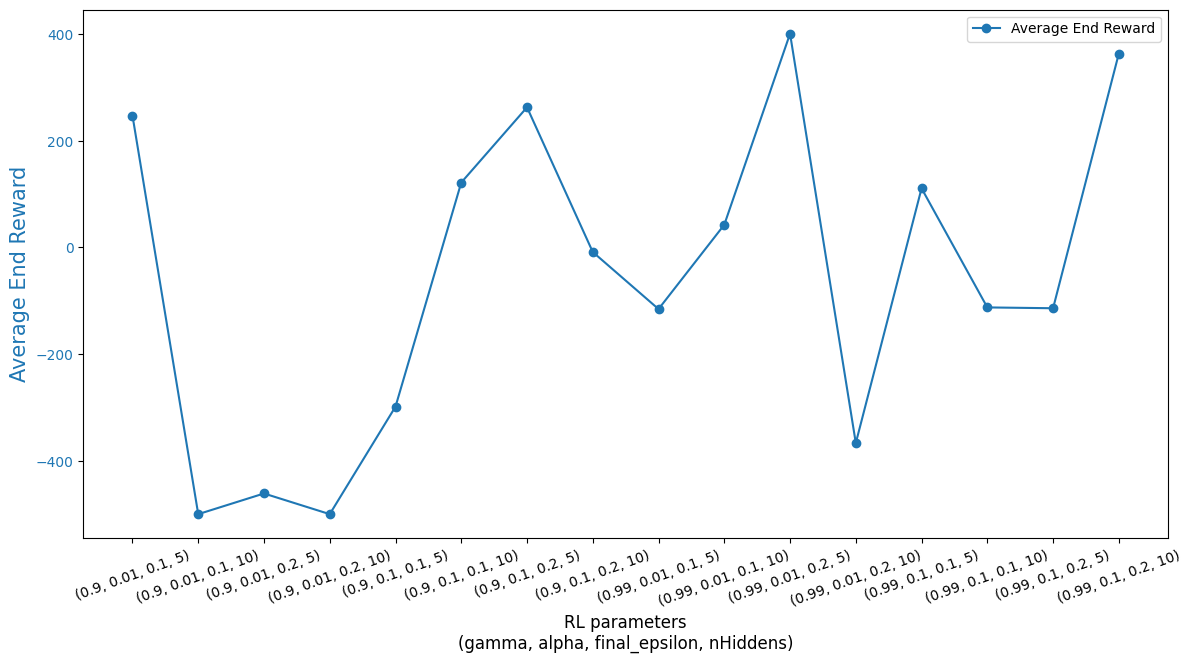

In [22]:
import warnings

warnings.filterwarnings('ignore')  # suppress warning on legend

fig, ax1 = plt.subplots(figsize=(14, 7), dpi=100)
gs_result.plot(x='RL_param', y='Average End Reward', marker='o', ax=ax1, color='C0')
ax1.set_xlabel('RL parameters\n(gamma, alpha, final_epsilon, nHiddens)', fontsize=12)
ax1.set_ylabel('Average End Reward', color='C0', fontsize=15)
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_xticks(np.arange(16))
ax1.set_xticklabels(gs_result.RL_param, rotation=20)
plt.show()

We use the chosen hyperparameter setting to train the RL and visualize our training performance as follows. We observe that although the best hyperparameters is chosen (based on the rewards), after 1000 episodes, the RLAgent does not seem to converge to a good point. The plot on the left shows the reward of each episode. The sum of rewards does not seem to be greater after the NN was trained throughout the episodes. The plot on the right shows the trace of the marble at the last episode. Starting at [2,2], the marble seems to be heading to the red region (the goal region) but the performance was not stable. 

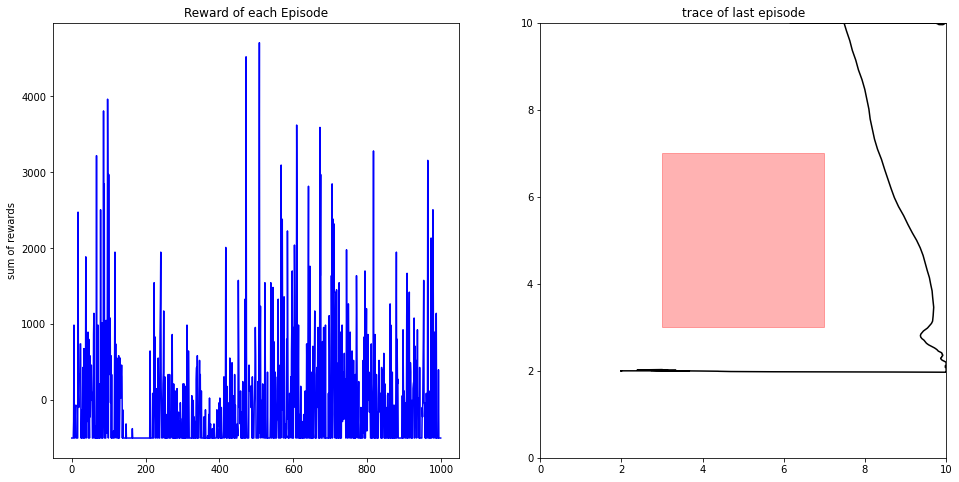

In [23]:
agent = RLAgent1(env=Marble2D())
agent.train(start=[2, 2], K=1000, gamma=0.9, rhoh=0.1, rhoo=0.1, epsilon=0.2,
                    nHiddens=5, verbose=False, plot=True)  # start at [2,2]

## Results for the Second Problem
We follow the hyper-parameter tuning strategy as the first problem in this case. We are to tune the:
- $\gamma$ (discounting factor)
- learning rate $\alpha$ (we tune `rhoh` and `rhoo` at the same time, named as $\alpha$)
- $\epsilon$ (we tune the **final epsilon value** only and **remains the initial epsilon value as 1**)
- no. of hidden neurons

We define the function below to locate good hyper-parameter combinations for our experiment. We use grid search to find the optimal combination of $(\gamma, \alpha, \epsilon, nHidden)$, in which $\gamma \in \lbrace0.9,0.99\rbrace, \alpha\in\lbrace0.01,0.1\rbrace, \epsilon\in\lbrace0.1,0.2\rbrace$, and nHiddens$\in\lbrace5,10\rbrace$.

We train the agent using 100 episodes and record the average end reward for the last 20 episodes, for each hyparameter setting.

In [ ]:
gs_result = grid_search_RL_params(RLAgent2, gym.make('MountainCar-v0'), [0.9, 0.99], [0.01, 0.1], [0.1, 0.2], [5, 10], debug=False)

Hyperparameter (0.9, 0.01, 0.1, 5) training starts...
Hyperparameter (0.9, 0.01, 0.1, 10) training starts...
Hyperparameter (0.9, 0.01, 0.2, 5) training starts...
Hyperparameter (0.9, 0.01, 0.2, 10) training starts...
Hyperparameter (0.9, 0.1, 0.1, 5) training starts...
Hyperparameter (0.9, 0.1, 0.1, 10) training starts...
Hyperparameter (0.9, 0.1, 0.2, 5) training starts...
Hyperparameter (0.9, 0.1, 0.2, 10) training starts...
Hyperparameter (0.99, 0.01, 0.1, 5) training starts...
Hyperparameter (0.99, 0.01, 0.1, 10) training starts...
Hyperparameter (0.99, 0.01, 0.2, 5) training starts...
Hyperparameter (0.99, 0.01, 0.2, 10) training starts...
Hyperparameter (0.99, 0.1, 0.1, 5) training starts...
Hyperparameter (0.99, 0.1, 0.1, 10) training starts...
Hyperparameter (0.99, 0.1, 0.2, 5) training starts...
Hyperparameter (0.99, 0.1, 0.2, 10) training starts...


In [ ]:
gs_result

,RL_param,Average End Reward
0,"(0.9, 0.01, 0.1, 5)",-200.0
1,"(0.9, 0.01, 0.1, 10)",-200.0
2,"(0.9, 0.01, 0.2, 5)",-200.0
3,"(0.9, 0.01, 0.2, 10)",-200.0
4,"(0.9, 0.1, 0.1, 5)",-200.0
5,"(0.9, 0.1, 0.1, 10)",-200.0
6,"(0.9, 0.1, 0.2, 5)",-200.0
7,"(0.9, 0.1, 0.2, 10)",-200.0
8,"(0.99, 0.01, 0.1, 5)",-200.0
9,"(0.99, 0.01, 0.1, 10)",-200.0


We use the following code to visualize the performance of hyperparameter settings. We observe that all the RLAgents leads to a -200 reward, meaning that none of them has been helping the car to reach the destination. We arbitrarily chose the hyperparameters $(\gamma, \alpha, \epsilon, nHidden)=(0.9, 0.2, 0.1, 10)$ and use this setting in our final model to visualize our agent training outcomes. 

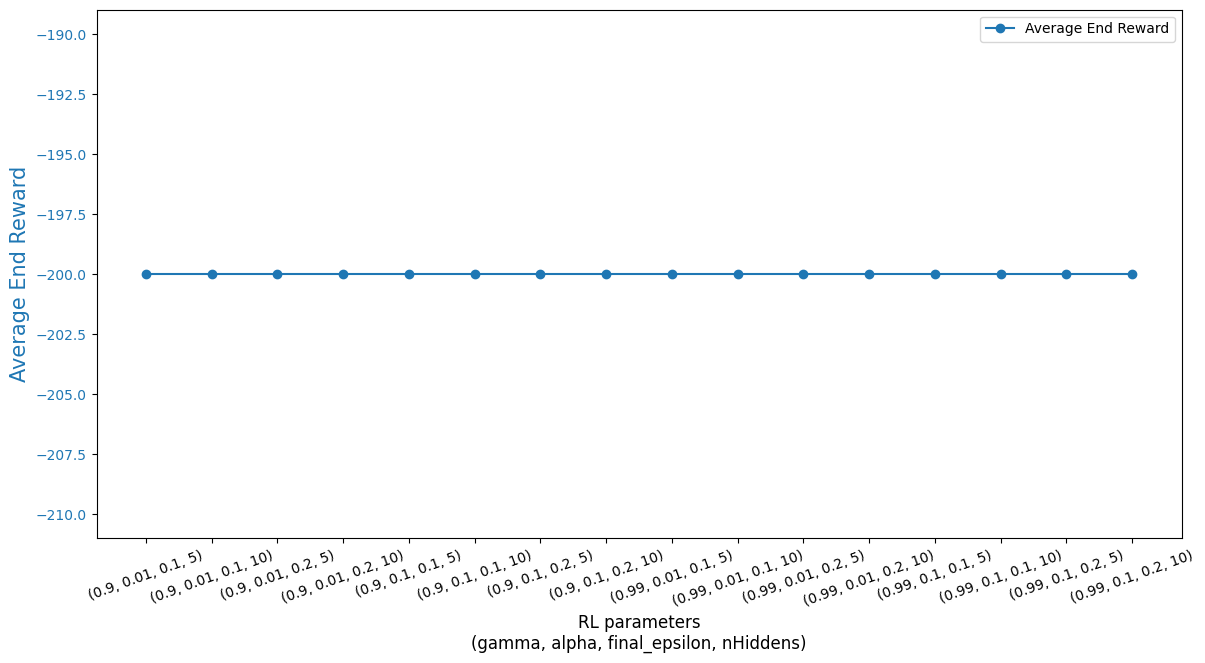

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 7), dpi=100)
gs_result.plot(x='RL_param', y='Average End Reward', marker='o', ax=ax1, color='C0')
ax1.set_xlabel('RL parameters\n(gamma, alpha, final_epsilon, nHiddens)', fontsize=12)
ax1.set_ylabel('Average End Reward', color='C0', fontsize=15)
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_xticks(np.arange(16))
ax1.set_xticklabels(gs_result.RL_param, rotation=20)
plt.show()

We use the chosen hyperparameter setting to train the RL and visualize our training performance as follows. We observe that after 100 episodes, the RLAgent does not seem to help the car reach to the destination even once. Seems to us the NN estimator is not converged to a good point. The plot below shows the reward of each episode, that throughout the episode the car is having a constant -200 reward. 

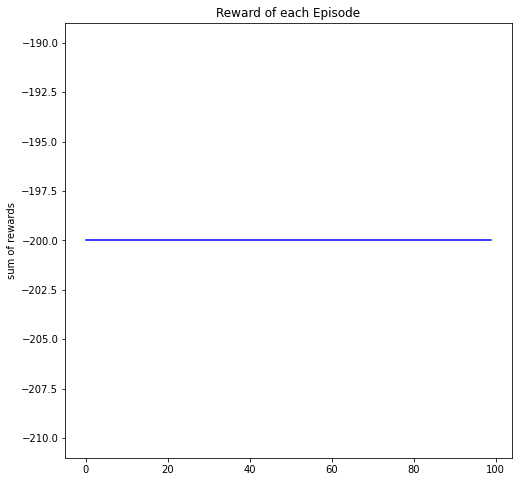

In [ ]:
agent = RLAgent2(env=gym.make('MountainCar-v0'))
agent.train(K=100, gamma=0.9, rhoh=0.1, rhoo=0.1, epsilon=0.2,
                    nHiddens=10, verbose=False, plot=True)

# V. Conclusions

**Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it.** 

In this assignment, we work on 2 RL problems using NN as the function estimator: the 2D marble movement problem and the mountain car problem. The marble environment are not hard to define and the RL problems are straightforward to solve. For the first problem, the greatest challenge we were facing is the convergence of the NN function estimator. The marble could not behave consistently and stay within the goal region. For the second problem, the greatest challenge was the right way to make the car move to its destination. We could not make the NN estimator converged to a point that can guarantee the car reach the destination. This might be due to the training episode is not enough for both estimators. 

# Extra Credit

You will be qualified to earn an extra credit when you solve both problems with complete experimental results and discussions, following the bullets in results section for both. 



## Grading

For this assignment, the grading rubric is a bit different. Please check it carefully. 


points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
25 | Problems | 
 |10| 2D Marble Class
 | 5| Explanation of problem and class implementation
 | 5| Explanation of mountain car problem
 | 5| explanation of the codes to use MountainCarContinuous-v0 from OpenAI Gym
25 | Methods | 
 |10| RLAgent1 for the first problem
 | 5| Explanation of the RLAgent1
 | 5| RLAgent2 for the first problem
 | 5| Explanation of the RLAgent2
40 | Results 
 | 5| Reports the selected parameters 
 |10| Experimental outputs that show the choice of parameters. How do you choose them?
 | 5| Visualization of learning and learned agent
 |10| Observations and analysis of learning results and plots
 |10| Results analysis (following the above four rubric criteria) for the second problem
5 | Conclusions 
